In [7]:
from sklearn.utils import all_estimators
import numpy as np
import pandas as pd
import os
import itertools
from IPython.display import clear_output
import matplotlib.pyplot as plt

import time

from sklearn.preprocessing import MinMaxScaler as mms

In [2]:
import pandas_profiling

ModuleNotFoundError: No module named 'pandas_profiling'

In [3]:
conda install -c conda-forge pandas-profiling

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\luisr\anaconda3

  added / updated specs:
    - pandas-profiling


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.0               |   py38haa244fe_1         3.1 MB  conda-forge
    pandas-profiling-1.4.1     |                0          40 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  pandas-profiling   conda-forge/win-64::pandas-profiling-1.4.1-0

The following packages will be UPDATED:

  conda                                4.9.2-py38haa244fe_0 --> 4.10.0-py38haa244fe_1




pandas-profiling-1.4 | 40 KB     |            |   0% 
pandas-profiling-1.4 | 40 KB     | ####       |  40% 
pandas-profiling-1.4 | 40 KB     | ########## | 100% 
p

In [1]:
!pip install -U pandas-profiling

ERROR: phik 0.11.2 has requirement scipy>=1.5.2, but you'll have scipy 1.5.0 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Acesso negado: 'C:\\Users\\Public\\Documents\\Wondershare\\CreatorTemp\\pip-uninstall-ux4macbz\\tqdm.exe'
Consider using the `--user` option or check the permissions.




  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=f3ed34aa31588d75e3aaddbca299d216d0a7e41cf334ab2b4fa18c8745bfc857
  Stored in directory: c:\users\luisr\appdata\local\pip\cache\wheels\23\14\6e\4be5bfeeb027f4939a01764b48edd5996acf574b0913fe5243
  Created wheel for phik: filename=phik-0.11.2-py3-none-any.whl size=1107415 sha256=bc079014120e05639b455251bfa8358956b5e56b18304149d283f39588ca2e0d
  Stored in directory: c:\users\luisr\appdata\local\pip\cache\wheels\72\9a\23\097c93fd8341220d92674891b6a9a30f0e389719d9b7291bd2
Successfully built htmlmin phik
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.47.0
    Uninstalling tqdm-4.47.0:
      Successfully uninstalled tqdm-4.47.0


In [4]:
from pandas_profiling import ProfileReport

In [8]:
import re

In [9]:
def intersection(lists):
    a=set(lists[0])
    for i in range(1,len(lists)):
        a = a.intersection(lists[i])
    return a

def n_top_intersection_analysis(top_lists):
    
    n_lists = len(top_lists)
    n_top_max = len(top_lists[0])    
    len_inter = []
    for i in range(1, n_top_max+1):
        
        top_lists_n = [top_lists[j][:i] for j in range(n_lists)]
        
        inter = len(intersection(top_lists_n))
        ttl=len(np.unique(np.array(top_lists_n)))
        len_inter.append([i, inter, inter/i, ttl, inter/ttl, ttl/i])

    len_inter_df = pd.DataFrame(len_inter, columns=['n top colunas mais importantes', 'interseção', 'interseção por n top',
                                                    'colunas unicas', 'interseção por colunas unicas', 'colunas unicas por n top'])
    return len_inter_df

def n_members_intersection_analysis(top_lists_org, n_members=2, rank_degree=2, rank_step=1):
       
    n_lists_org = len(top_lists_org)
    n_top_max = len(top_lists_org[0])    
    
    groups = list(itertools.combinations(range(n_lists_org), n_members))
    n_groups = len(groups)
    groups_stats = []
    cnt_grp = 0
    
    for group in groups:
              
        
        top_lists = [top_lists_org[member] for member in group]
        n_lists = len(top_lists)

        
        loop = np.array(range(rank_step, n_top_max+1, rank_step))**rank_degree
        stop=0
        for i in loop:
    
            if i>=n_top_max+1:
                stop+=1
                i = n_top_max+1
                if stop==2: break

            clear_output(wait=True)
            print('Grupo {}/{} - {}/{}'.format(cnt_grp, n_groups, i, n_top_max))
                 
            top_lists_n = [top_lists[j][:i] for j in range(n_lists)]

            inter = len(intersection(top_lists_n))
            unique = len(np.unique(np.array(top_lists_n)))

            groups_stats.append([group, n_members, i, inter, inter/i, unique, inter/unique, unique/i])
        
        cnt_grp+=1

    groups_df = pd.DataFrame(groups_stats, columns=['group', 'n_members', 'n top colunas mais importantes', 'interseção', 'interseção por n top',
                                                        'colunas unicas', 'interseção por colunas unicas', 'colunas unicas por n top'])
    
    return groups_df

def n_top_combinations_intersection_analyses(top_lists_org, max_members, member_step, rank_degree=2, rank_step=1):
    
    n_members_lst = []
    for n_members in range(2, max_members+1, member_step):
        
        n_stats = n_members_intersection_analysis(top_lists_org, n_members=n_members, rank_degree=rank_degree, rank_step=rank_step)
        n_members_lst.append(n_stats)
    
    n_members_df = pd.concat(n_members_lst, axis=0)
    
    return n_members_df

In [10]:
def groups_inter(n_members_df0, n_members=2, x_col='n top colunas mais importantes', xlim=None, ylim=None, figsize=(14,12)):
    
    n_members_df = n_members_df0[n_members_df0['n_members']==n_members]
    groups = n_members_df['group'].unique()
    n_grps=len(groups)
    
    fig = plt.figure(figsize=figsize)
    axs = [fig.add_subplot(3,2,i) for i in range(1,6)]
    for i, col in enumerate(n_members_df.columns[3:]):

        
        cnt_grp=1
        
        for group in groups:
            
            clear_output(wait=True)
            print('Desenhando Variável {}/{} - Grupo {}/{}'.format(i+1, 5, cnt_grp, n_grps))
            n_members_df[n_members_df['group']==group].plot(x_col, col, ax=axs[i])
            cnt_grp+=1
            
        
        axs[i].legend([])
        axs[i].set(xlim=xlim, ylim=ylim, title=col)
        axs[i].grid()
        
    plt.show()
    plt.pause(0.1)

def members_inter(n_members_df, x_col='n top colunas mais importantes', xlim=None, ylim=None, marker=None):
    
    fig = plt.figure(figsize=(14,9))

    axs = [fig.add_subplot(3,2,i) for i in range(1,6)]

    for i, col in enumerate(n_members_df.columns[3:]):

        clear_output(wait=True)
        
        for member in range(2, n_members_df['n_members'].max()+1):
            
            #n_members_df.groupby(['n_members', x_col]).mean().reset_index()
            n_members_df[n_members_df['n_members']==member].groupby([x_col]).mean().reset_index().plot(x_col, col, ax=axs[i], marker=marker)
        
        axs[i].legend([])
        axs[i].set(xlim=xlim, ylim=ylim, title=col)
        axs[i].grid()
        
    plt.show()
    plt.pause(0.1)

In [11]:
def scatter_3d(data, xyz, how='scatter', figsize=(8,5), c=None, cmap=plt.get_cmap('Spectral')):
    
    x, y, z = [data[X] for X in xyz]
    xlabel, ylabel, zlabel = [X for X in xyz]
    if type(c)!=type(None):
        print('Alterando escala para esquema de cores...')
        
        labels_trans = mms().fit_transform(data[[c]].values).ravel()
        c = cmap(labels_trans)
    
    if how=='rotate':
        for angle in range(0, 360, 10):

            fig = plt.figure(figsize=figsize)
            axs = fig.add_subplot(projection='3d')
            axs.scatter(x, y, z, c=c)
            axs.set(xlabel=xlabel, ylabel=ylabel, zlabel=zlabel)
            
            axs.view_init(8, angle)
            clear_output(wait=True)
            plt.show()
            plt.pause(0.01)

    else:
        print('Configurando figura...')
        clear_output(wait=True)
        fig = plt.figure(figsize=figsize)
        axs = fig.add_subplot(projection='3d')
        axs.set(xlabel=xlabel, ylabel=ylabel, zlabel=zlabel)

        if how=='scatter':
            print('Desenhando pontos...')
            axs.scatter(x, y, z, c=c)
            print('Imprimindo pontos...')
            time.sleep(0.6)
            plt.show()
            plt.pause(0.1)
            print('Pontos desenhandos!')
        elif how=='trisurf':
            axs.plot_trisurf(x, y, z)   


def lines_3d(data, xyz, how='scatter', figsize=(8,5), c='label', cmap=plt.get_cmap('Spectral')):
    
    xlabel, ylabel, zlabel = [X for X in xyz]
    fitted_mms = mms().fit(data[[c]].values)
    
    if how=='rotate':
        for angle in range(0, 360, 10):

            fig = plt.figure(figsize=figsize)
            axs = fig.add_subplot(projection='3d')
            axs.scatter(x, y, z, c=c)
            axs.set(xlabel=xlabel, ylabel=ylabel, zlabel=zlabel)
            
            axs.view_init(8, angle)
            clear_output(wait=True)
            plt.show()
            plt.pause(0.01)

    else:
        print('Configurando figura...')
        clear_output(wait=True)
        fig = plt.figure(figsize=figsize)
        axs = fig.add_subplot(projection='3d')
        axs.set(xlabel=xlabel, ylabel=ylabel, zlabel=zlabel)
    
        groups = data['group'].unique()
        n_grps = len(groups)
        for grp, group in enumerate(groups):
                
            grp_data = data[data['group']==group]
            grp_c = grp_data[c]
            x, y, z = [grp_data[X] for X in xyz]

            if type(c)!=type(None):
                
                labels_trans = fitted_mms.transform(grp_data[[c]].values).ravel()
                c_plot = cmap(labels_trans)[0]
            
            clear_output(wait=True)
            print('Desenhando linhas... {}/{}'.format(grp, n_grps))
            axs.plot(x, y, z, color=c_plot)

            
        print('Imprimindo pontos...')
        time.sleep(0.6)
        plt.show()
        plt.pause(0.1)
        print('Pontos Impressos!')
    

In [12]:
def simple_groups_inter(n_members_df, cols=['interseção por n top'], n_members=2, x_col='n top colunas mais importantes', figsize=(20,12), xlim=None, ylim=None, colors=None, legend=[]):
    
    if cols==None: cols = n_members_df.columns[3:-1].tolist()

    groups = n_members_df['group'].unique()
    labels = n_members_df.groupby('group').mean()['label'].loc[groups].values
    
    n_grps=len(groups)
    if type(colors)==type(None): 
        colors=[None]*n_grps
    elif colors=='auto':
        colors_float = n_members_df.groupby('group').mean()[['label']].loc[groups]
        colors=cmap(mms().fit_transform(colors_float).ravel())
    elif type(colors)==type(dict()):
        colors = [colors[name] for name in groups]

   
    fig = plt.figure(figsize=figsize)
    axs = [fig.add_subplot(3,2,i) for i in range(1, len(cols)+1)]
    for i, col in enumerate(cols):
        
        cnt_grp=1
        for group, color, label in zip(groups, colors, labels):
            
            group_df = n_members_df[n_members_df['group']==group]
            
            clear_output(wait=True)
            print('Desenhando Variável {}/{} - Grupo {}/{}'.format(i+1, len(cols), cnt_grp, n_grps))
            axs[i].plot(group_df[x_col], group_df[col], c=color)
            cnt_grp+=1
            
        
        axs[i].legend([])
        axs[i].set(xlim=xlim, ylim=ylim, title=col)
        axs[i].grid()
        
    plt.show()
    plt.pause(0.1)

In [13]:
def as_tuple(str_tuple_lst):
    new_lst = []
    for str_tuple in str_tuple_lst:
        
        new_lst+=[int(re.findall('[0-9]*,', str_tuple)[0][:-1]), int(re.findall(' [0-9]*', str_tuple)[0][1:])]

    return np.unique(new_lst)

In [14]:
def extract_ranks(X, names):
    
    tops = []
    labels = X['label'].unique()
    for i in labels:

        top_names = as_tuple(X[X['label']==i].index.tolist())
        top_names = [names[name] for name in top_names]
        tops.append(top_names)

    tops_df = pd.DataFrame(tops, index=labels).T
    
    return tops_df

In [ ]:
colors_dict = {label:c[label] for label in (X['label'].unique())}

In [478]:
data = members_2_c
c='label'
labels_trans = mms().fit_transform(data[[c]].values).ravel()


In [479]:
labels_map = cmap(labels_trans)

### Recarregando Ranks

In [6]:
ranks_path = 'Feature Selection/Ranks/'

ranks_files = os.listdir(ranks_path)

ranks_lst = [pd.read_csv(ranks_path+rank_file, index_col=0) for rank_file in ranks_files]

In [7]:
coef_names = [col[:-4] for col in ranks_files]

In [8]:
ranks_df = pd.concat(ranks_lst, axis=1)
ranks_df.columns = coef_names[:]

# Ranks Analysis

### Ordenando Ranks Carregados

In [9]:
sorted_ranks_lst = [rank.reset_index().sort_values(['0', 'index'])['index'].tolist() for rank in ranks_lst]

### Contagem do N° de Combinações de 18 para grupos de tamanho n

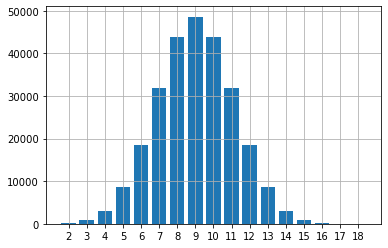

In [10]:
n_items = list(range(1, len(coef_names)+1))

n_combs = [len(list(itertools.combinations(n_items, i))) for i in n_items[1:]]

plt.bar(n_items[1:], n_combs)
plt.xticks(n_items[1:])
plt.grid()
plt.show()

### Análise da interseção para combinações de 2 (grau 2)

In [71]:
members_2 = n_members_intersection_analysis(sorted_ranks_lst, n_members=2, rank_step=1, rank_degree=2)

Grupo 152/153 - 8820/8819


### Análise da interseção para combinações de 2 a 5

In [42]:
members_to_5 = n_top_combinations_intersection_analyses(sorted_ranks_lst, max_members=5, member_step=1, rank_degree=5, rank_step=1)

Grupo 8567/8568 - 8820/8819


### Análise da interseção para combinações de 2 (COMPLETA)

In [249]:
members_2_full = n_members_intersection_analysis(top_lists_org = sorted_ranks_lst, n_members=2, rank_step=1, rank_degree=1)

Grupo 152/153 - 8819/8819


### Salvando Análises

In [48]:
#members_to_5.to_csv('Feature Selection/análise_interseção_ranks_até_5_membros.csv')
print(datetime.now())

2021-03-31 22:45:16.991634


In [254]:
#members_2_full.to_csv('Feature Selection/análise_interseção_combinações_de2_ranks_completa.csv')
print(datetime.now())

2021-04-01 15:24:58.109669


### Recarregando

In [430]:
members_2 = pd.read_csv('Feature Selection/análise_interseção_combinações_de2_ranks_completa.csv', index_col=0)

### Imprimindo Resultado Geral

In [11]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
members_inter(members_to_5)

Desenhando Variável 1/1 - Grupo 153/153


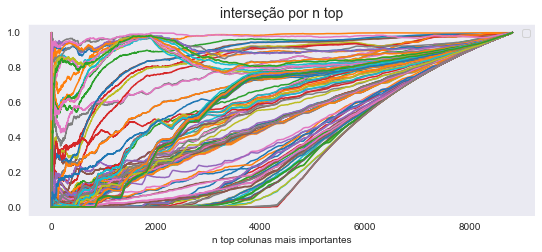

In [445]:
simple_groups_inter(members_2, cols=['interseção por n top'])

In [ ]:
groups_inter(members_2)

# AGRUPANDO

In [446]:
from clusteval import clusteval

In [447]:
def build_X(df, n_top, cols):

    x_col = 'n top colunas mais importantes'
    X = df[df[x_col]==n_top].set_index('group').iloc[:, cols]
    
    return X

In [600]:
def cluster_X(X, cluster='kmeans', cmap=plt.get_cmap('Spectral')):

    ce = clusteval(cluster=cluster)
    ce_dict = ce.fit(X.values)
    X['label'] = ce_dict['labx']
#    c = [cmap(np.random.random()) for i in range(len(X['label'].unique()))]
    
    n_labels = len(X['label'].unique())
    c = cmap(mms().fit_transform(X['label'].unique().reshape(n_labels,1)).ravel())
    colors_dict = {name:c[label] for name, label in zip(X.index, X['label'])}
    return X, colors_dict, c

In [553]:
cols_combs = list(itertools.combinations(members_2.columns[-6:], 3))
cmap = plt.get_cmap('Spectral')

# 1. Usando Média em 4000

In [663]:
X = build_X(members_2, n_top=4000, cols=[-4])

In [664]:
X, colors_dict, c = cluster_X(X, cluster='kmeans')

 13%|██████████▊                                                                        | 3/23 [00:00<00:00, 26.86it/s]


[clusteval] >Fit using kmeans with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 15.24it/s]

[clusteval] >Optimal number clusters detected: [5].
[clusteval] >Fin.


In [665]:
members_2_c = pd.merge(members_2, X.reset_index()[['group', 'label']], on='group')

Desenhando Variável 1/1 - Grupo 153/153


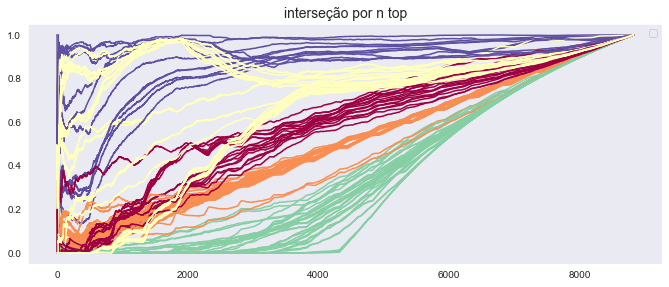

In [661]:
simple_groups_inter(members_2_c, cols=['interseção por n top'],
                    n_members=2, x_col='n top colunas mais importantes',
                    figsize=(25,15), xlim=None, ylim=None, colors=colors_dict,
                    legend=[]) 

In [ ]:
for cols in cols_combs:
    lines_3d(members_2_c, cols, how='scatter', c='label')
    print('Desenho Carregado')
    time.sleep(1)
    if input()=='exit': break

In [668]:
ranks_1800 = extract_ranks(X, ranks_files); ranks_1800

,-1,3,0,1,2
0,AdaBoostClassifier.csv,AdaBoostClassifier.csv,BernoulliNB.csv,BernoulliNB.csv,BernoulliNB.csv
1,BernoulliNB.csv,ComplementNB.csv,ComplementNB.csv,ComplementNB.csv,ExtraTreesClassifier.csv
2,ComplementNB.csv,DecisionTreeClassifier.csv,LinearDiscriminantAnalysis.csv,ExtraTreesClassifier.csv,LinearDiscriminantAnalysis.csv
3,DecisionTreeClassifier.csv,ExtraTreeClassifier.csv,LinearSVC.csv,LinearDiscriminantAnalysis.csv,LinearSVC.csv
4,ExtraTreeClassifier.csv,GradientBoostingClassifier.csv,LogisticRegression.csv,LinearSVC.csv,LogisticRegression.csv
5,ExtraTreesClassifier.csv,LinearSVC.csv,LogisticRegressionCV.csv,LogisticRegression.csv,LogisticRegressionCV.csv
6,GradientBoostingClassifier.csv,LogisticRegression.csv,MultinomialNB.csv,LogisticRegressionCV.csv,PassiveAggressiveClassifier.csv
7,LinearDiscriminantAnalysis.csv,LogisticRegressionCV.csv,PassiveAggressiveClassifier.csv,MultinomialNB.csv,Perceptron.csv
8,LinearSVC.csv,MultinomialNB.csv,Perceptron.csv,PassiveAggressiveClassifier.csv,RandomForestClassifier.csv
9,LogisticRegression.csv,PassiveAggressiveClassifier.csv,RidgeClassifier.csv,Perceptron.csv,RidgeClassifier.csv


# 2. Usando Média 1800

In [669]:
X = build_X(members_2, 1800, [-4])

In [719]:
X, colors_dict, c = cluster_X(X, 'kmeans')

 17%|██████████████▍                                                                    | 4/23 [00:00<00:00, 28.05it/s]


[clusteval] >Fit using kmeans with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 15.58it/s]

[clusteval] >Optimal number clusters detected: [8].
[clusteval] >Fin.


In [720]:
members_2_c = pd.merge(members_2, X.reset_index()[['group', 'label']], on='group')

Desenhando Variável 1/1 - Grupo 153/153


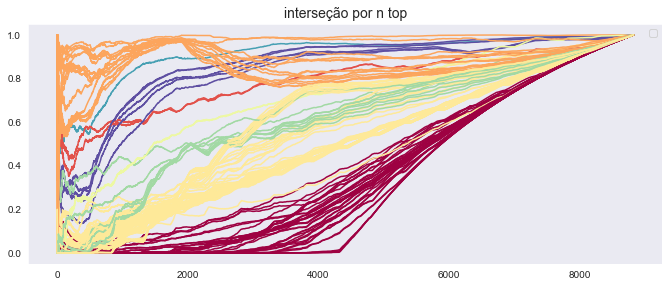

In [721]:
simple_groups_inter(members_2_c, cols=['interseção por n top'],
                    n_members=2, x_col='n top colunas mais importantes',
                    figsize=(25,15), xlim=None, ylim=None, colors=colors_dict) # Feito com Média Geral

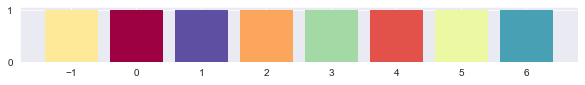

In [722]:
legend = {label:c[label] for label in X['label'].unique()}

fig, ax = plt.subplots(figsize=(10,1))
axs = ax.bar(legend.keys(), np.ones(len(legend)))
for child, color in zip(axs.get_children(), legend.values()):
    child.set_color(color)

In [723]:
ranks_1800 = extract_ranks(X, ranks_files); ranks_1800

,-1,6,1,4,0,3,5,2
0,AdaBoostClassifier.csv,AdaBoostClassifier.csv,AdaBoostClassifier.csv,BernoulliNB.csv,BernoulliNB.csv,BernoulliNB.csv,ComplementNB.csv,ComplementNB.csv
1,BernoulliNB.csv,DecisionTreeClassifier.csv,DecisionTreeClassifier.csv,ComplementNB.csv,ComplementNB.csv,ExtraTreesClassifier.csv,LinearDiscriminantAnalysis.csv,LinearSVC.csv
2,ComplementNB.csv,None,ExtraTreeClassifier.csv,MultinomialNB.csv,ExtraTreesClassifier.csv,LinearDiscriminantAnalysis.csv,MultinomialNB.csv,LogisticRegression.csv
3,DecisionTreeClassifier.csv,None,GradientBoostingClassifier.csv,None,LinearDiscriminantAnalysis.csv,LinearSVC.csv,None,LogisticRegressionCV.csv
4,ExtraTreeClassifier.csv,None,None,None,LinearSVC.csv,LogisticRegression.csv,None,MultinomialNB.csv
5,ExtraTreesClassifier.csv,None,None,None,LogisticRegression.csv,LogisticRegressionCV.csv,None,PassiveAggressiveClassifier.csv
6,GradientBoostingClassifier.csv,None,None,None,LogisticRegressionCV.csv,PassiveAggressiveClassifier.csv,None,Perceptron.csv
7,LinearDiscriminantAnalysis.csv,None,None,None,MultinomialNB.csv,Perceptron.csv,None,SGDClassifier.csv
8,LinearSVC.csv,None,None,None,PassiveAggressiveClassifier.csv,RandomForestClassifier.csv,None,None
9,LogisticRegression.csv,None,None,None,Perceptron.csv,RidgeClassifier.csv,None,None


# 2. Usando Média 200

In [727]:
X = build_X(members_2, 300, [-4])

In [728]:
X, colors_dict, c = cluster_X(X, 'kmeans')

  4%|███▌                                                                            | 11/245 [00:00<00:02, 104.05it/s]


[clusteval] >Fit using dbscan with metric: euclidean, and linkage: ward
[clusteval] >Normalize data (unit variance, zero-mean).
[clusteval] >Gridsearch across epsilon..
[clusteval] >Evaluate using silhouette..


100%|███████████████████████████████████████████████████████████████████████████████| 245/245 [00:01<00:00, 148.46it/s]

[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [3].
[clusteval] >Fin.


In [729]:
members_2_c = pd.merge(members_2, X.reset_index()[['group', 'label']], on='group')

Desenhando Variável 1/1 - Grupo 153/153


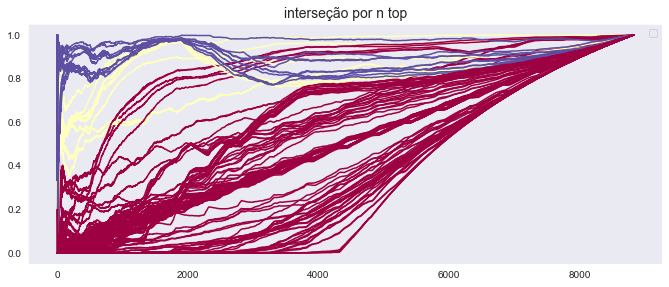

In [730]:
simple_groups_inter(members_2_c, cols=['interseção por n top'],
                    n_members=2, x_col='n top colunas mais importantes',
                    figsize=(25,15), xlim=None, ylim=None, colors=colors_dict) # Feito com Média Geral

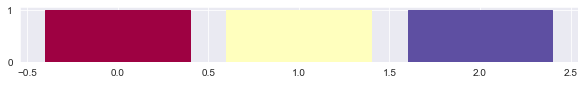

In [731]:
legend = {label:c[label] for label in X['label'].unique()}

fig, ax = plt.subplots(figsize=(10,1))
axs = ax.bar(legend.keys(), np.ones(len(legend)))
for child, color in zip(axs.get_children(), legend.values()):
    child.set_color(color)

In [732]:
ranks_1800 = extract_ranks(X, ranks_files); ranks_1800

,0,1,2
0,AdaBoostClassifier.csv,AdaBoostClassifier.csv,LogisticRegression.csv
1,BernoulliNB.csv,BernoulliNB.csv,LogisticRegressionCV.csv
2,ComplementNB.csv,ComplementNB.csv,PassiveAggressiveClassifier.csv
3,DecisionTreeClassifier.csv,DecisionTreeClassifier.csv,Perceptron.csv
4,ExtraTreeClassifier.csv,LinearSVC.csv,SGDClassifier.csv
5,ExtraTreesClassifier.csv,LogisticRegression.csv,None
6,GradientBoostingClassifier.csv,LogisticRegressionCV.csv,None
7,LinearDiscriminantAnalysis.csv,MultinomialNB.csv,None
8,LinearSVC.csv,PassiveAggressiveClassifier.csv,None
9,LogisticRegression.csv,Perceptron.csv,None


In [16]:
import imblearn

In [28]:
from imblearn import ensemble??

Type:        module
String form: <module 'imblearn.ensemble' from 'C:\\Users\\luisr\\anaconda3\\lib\\site-packages\\imblearn\\ensemble\\__init__.py'>
File:        c:\users\luisr\anaconda3\lib\site-packages\imblearn\ensemble\__init__.py
Source:     
"""
The :mod:`imblearn.ensemble` module include methods generating
under-sampled subsets combined inside an ensemble.
"""

from ._easy_ensemble import EasyEnsembleClassifier
from ._bagging import BalancedBaggingClassifier
from ._forest import BalancedRandomForestClassifier
from ._weight_boosting import RUSBoostClassifier

__all__ = [
    "BalancedBaggingClassifier",
    "BalancedRandomForestClassifier",
    "EasyEnsembleClassifier",
    "RUSBoostClassifier",
]


In [ ]:
from imblearn import ensemble

In [27]:
?from imblearn import ensemble

Object `from imblearn import ensemble` not found.


In [31]:
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier

imb_ensemble = [
    BalancedBaggingClassifier,
    BalancedRandomForestClassifier,
    EasyEnsembleClassifier,
    RUSBoostClassifier]
imb_names = [
    "BalancedBaggingClassifier",
    "BalancedRandomForestClassifier",
    "EasyEnsembleClassifier",
    "RUSBoostClassifier"]
imb_params = [imb().get_params() for imb in imb_ensemble]